# Names and Affiliations

Here we will just take a look at some of avenues of inconsistent practices regarding metadata. We'll look at Korean author names, representation of 'Korea' within personal affiliations, and 'Brasil' in personal affiliations. This isn't particularly exhaustive and only looks at these specific cases, but could be a starting point for other avenues.

First we'll import our frequently used libraries and our data.

In [1]:
import pandas as pd #Creating dataframe and manipulating data
import re #regular expressions used for detection of initials
import seaborn as sns # data visualizations
from pathlib import Path
import numpy as np
import ast

In [2]:
# Data Directory
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
# Loading in dataset
df = pd.read_csv(output_dir / '04_language_detection.csv',
                 parse_dates=['created', 'deposited'],
                 infer_datetime_format=True, 
                 index_col='Index')
pd.set_option('mode.chained_assignment', None)

For clarity, we'll adjust how `lang_type` is labeled in the dataset; going from a numerical labeling to an explicit word-label: `English, Monolingual (excl. en),` and `Multilingual`

In [3]:
df.lang_type.replace(0, 'English', inplace=True)
df.lang_type.replace(1, 'Monolingual (excl. en)', inplace=True)
df.lang_type.replace(2, 'Multilingual', inplace=True)

To effectively parse certain columns, we'll need to evaluate them so that pandas and python recognize the data structures they are in.

In [4]:
def reformat_col(record):
    try:
        formed = ast.literal_eval(record)
        return formed
    except:
        return None

cols_to_reformat = ['detected_lang', 'author']
for col in cols_to_reformat:
    df[col] = df[col].apply(lambda x: reformat_col(x))

We are only concerned with records that have authors. So we will filter out records without, then we'll `explode` the dataframe so that each author has their own row within the dataframe. After that, we will then seperate the different facets of the *author* column (*given, family, affiliation,* etc) into their own columns.

In [5]:
# Removing records without authors
name_df = df.loc[df.author.notnull()]
# Giving each author their own row
name_df = name_df.explode('author')
# Creating columns for the different author-facets
author_series = name_df.author.apply(pd.Series)
# Creating the new Dataframe
bn = pd.concat([name_df.drop(['author'], axis=1), author_series], axis=1)
bn

,publisher,DOI,created,title,container-title,language,deposited,published,abstract,original-title,...,lang_match,lang_type,given,family,sequence,affiliation,ORCID,authenticated-orcid,name,suffix
Index,,,,,,,,,,,,,,,,,,,,,
0,Wiley,10.1002/(sici)1099-1727(200021)16:1<27::aid-sd...,2002-09-10,The validation of commercial system dynamics m...,System Dynamics Review,en,2021-07-01,2000.0,NaN,NaN,...,0.0,English,Geoff,Coyle,first,[],NaN,NaN,NaN,NaN
0,Wiley,10.1002/(sici)1099-1727(200021)16:1<27::aid-sd...,2002-09-10,The validation of commercial system dynamics m...,System Dynamics Review,en,2021-07-01,2000.0,NaN,NaN,...,0.0,English,David,Exelby,additional,[],NaN,NaN,NaN,NaN
1,Springer Science and Business Media LLC,10.1007/bf02653972,2007-07-17,Effect of system geometry on the leaching beha...,Metallurgical Transactions B,en,2019-05-20,1979.0,NaN,NaN,...,0.0,English,C.,Vu,first,[],NaN,NaN,NaN,NaN
1,Springer Science and Business Media LLC,10.1007/bf02653972,2007-07-17,Effect of system geometry on the leaching beha...,Metallurgical Transactions B,en,2019-05-20,1979.0,NaN,NaN,...,0.0,English,K. N.,Han,additional,[],NaN,NaN,NaN,NaN
2,Wiley,10.1111/reel.12221,2017-12-01,The international law on transboundary haze po...,"Review of European, Comparative &amp; Internat...",en,2017-12-01,2017.0,NaN,NaN,...,0.0,English,Shawkat,Alam,first,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106106,Elsevier BV,10.1016/j.carbpol.2021.118782,2021-10-21,Antibacterial porous sponge fabricated with ca...,Carbohydrate Polymers,en,2023-01-06,2022.0,NaN,NaN,...,0.0,English,Qing,Xu,additional,[],NaN,NaN,NaN,NaN
106106,Elsevier BV,10.1016/j.carbpol.2021.118782,2021-10-21,Antibacterial porous sponge fabricated with ca...,Carbohydrate Polymers,en,2023-01-06,2022.0,NaN,NaN,...,0.0,English,Yue,Ma,additional,[],NaN,NaN,NaN,NaN
106106,Elsevier BV,10.1016/j.carbpol.2021.118782,2021-10-21,Antibacterial porous sponge fabricated with ca...,Carbohydrate Polymers,en,2023-01-06,2022.0,NaN,NaN,...,0.0,English,Boyuan,Li,additional,[],NaN,NaN,NaN,NaN


Now we will clean up the *affiliation* column. At this point, each row has a `list` in the *affiliation* column. For many, it is an empty `list`, meaning that there is no affiliation for that author in the record.

We will convert those empty lists no `NaN` values for more effective parsing, in cases where an author has a single affiliation we will remove it from the `list` and return the affiliation as a `string`. If an author has multiple affiliations, we will maintain the `list` structure.

In [6]:
def affiliation_fix(affil):
    try:
        # Author only has one affiliation, return the string value
        if len(affil) == 1:
            return affil[0]['name']
        elif len(affil) > 1:
            # if they have multiple, return a cleaner list of their affiliations
            names = [i['name'] for i in affil]
            return names
        else:
            # if the affiliation is an empty list, convert to NaN
            return np.nan
    except:
        return np.nan
bn['affiliation'] = bn.affiliation.map(lambda x: affiliation_fix(x))

In [7]:
bn.loc[bn.affiliation.notnull()]

,publisher,DOI,created,title,container-title,language,deposited,published,abstract,original-title,...,lang_match,lang_type,given,family,sequence,affiliation,ORCID,authenticated-orcid,name,suffix
Index,,,,,,,,,,,,,,,,,,,,,
25,Instituto Politecnico Nacional,10.35426/iav51n123.02,2022-07-08,Modelo Predictivo de Predisposición y Compromi...,Investigación Administrativa,es,2022-07-08,2022.0,El objetivo del presente trabajo es validar un...,['Predictive Model of Organizational Bias and ...,...,0.0,Monolingual (excl. en),Mariana Ivonne,Nava-Soto,first,"Universidad Autónoma de Ciudad Juárez , México",http://orcid.org/0000-0001-9273-2783,False,NaN,NaN
25,Instituto Politecnico Nacional,10.35426/iav51n123.02,2022-07-08,Modelo Predictivo de Predisposición y Compromi...,Investigación Administrativa,es,2022-07-08,2022.0,El objetivo del presente trabajo es validar un...,['Predictive Model of Organizational Bias and ...,...,0.0,Monolingual (excl. en),Emmanuel Francisco,García-Uribe,additional,"Universidad Autónoma de Ciudad Juárez , México",http://orcid.org/0000-0003-4069-197X,False,NaN,NaN
25,Instituto Politecnico Nacional,10.35426/iav51n123.02,2022-07-08,Modelo Predictivo de Predisposición y Compromi...,Investigación Administrativa,es,2022-07-08,2022.0,El objetivo del presente trabajo es validar un...,['Predictive Model of Organizational Bias and ...,...,0.0,Monolingual (excl. en),Patricia,Ramos-Rubio,additional,"Universidad Autónoma de Ciudad Juárez , México",http://orcid.org/0000-0003-3979-2431,False,NaN,NaN
38,Brill,10.1163/22131035-00602001,2017-12-11,How Conditional Amnesties Can Assist Transitio...,International Human Rights Law Review,NaN,2019-06-05,2017.0,This article explores how conditional amnestie...,NaN,...,1.0,English,Jeremy Julian,Sarkin,first,ba llb (Natal) llm (Harvard) lld (uwc) Profess...,NaN,NaN,NaN,NaN
68,"Harborside Press, LLC",10.6004/jnccn.2008.0002,2017-04-14,Modifying Cancer-Related Fatigue by Optimizing...,Journal of the National Comprehensive Cancer N...,NaN,2019-02-28,2008.0,Cancer-related fatigue is reported by patients...,NaN,...,1.0,English,Ann Malone,Berger,first,abFrom the University of Nebraska Medical Cent...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106105,Oxford University Press (OUP),10.1002/bjs.1155,2006-06-16,Authors' reply,British Journal of Surgery,en,2021-07-10,1999.0,NaN,NaN,...,0.0,English,R E K,Marshall,first,"Department of Surgery, 2nd Floor, New Guy's Ho...",NaN,NaN,NaN,NaN
106105,Oxford University Press (OUP),10.1002/bjs.1155,2006-06-16,Authors' reply,British Journal of Surgery,en,2021-07-10,1999.0,NaN,NaN,...,0.0,English,A,Anggiansah,additional,"Department of Surgery, 2nd Floor, New Guy's Ho...",NaN,NaN,NaN,NaN
106105,Oxford University Press (OUP),10.1002/bjs.1155,2006-06-16,Authors' reply,British Journal of Surgery,en,2021-07-10,1999.0,NaN,NaN,...,0.0,English,W A,Owen,additional,"Department of Surgery, 2nd Floor, New Guy's Ho...",NaN,NaN,NaN,NaN


### Affiliations
There are 66,409 authors with affiliations in our dataset.

I decided to look into how nations are represented when listed in their affiliation, for example is the location or name of an institution written with 'Brasil' or 'Brazil'.

To get an idea of this, we'll use `thefuzz`, a package that employs Levenshein Distance, or how many single-character edits are required to get from one string to the next.

While there is a range of interesting possibilities with this, here we will just use it to guage differences in national representation.

In [8]:
from thefuzz import fuzz
from thefuzz import process

bn['affiliation'] = bn['affiliation'].str.lower()
bn['affiliation'] = bn['affiliation'].str.strip()
affils = bn.affiliation.unique()
matches = process.extract("korea", affils, limit=15, scorer=fuzz.token_set_ratio)
matches

[('department of media & communication, sungkyunkwan university, seoul, south korea',
  100),
 ('beamline department; pohang accelerator laboratory (pal); pohang 790-784 republic of korea',
  100),
 ('jeonju center; korea basic science institute; jeonju jeollabuk-do 54907 republic of korea',
  100),
 ('department of information and communication engineering; daegu gyeongbuk institute of science and technology; daegu 711-873 republic of korea',
  100),
 ('department of physics; hanyang university; seoul 133-791 republic of korea',
  100),
 ('department of bionanotechnology, hanyang university, sangnok-gu hanyang daehak-ro 55, ansan, gyeonggi-do 15588, republic of korea',
  100),
 ('center for neuro-medicine, korea institute of science and technology (kist), seongbuk-gu hwarangro 14-gil 5, seoul 136-791, republic of korea',
  100),
 ('department of applied chemistry, hanyang university, sangnok-gu hanyang daehak-ro 55, ansan, gyeonggi-do, 15588, republic of korea',
  100),
 ('department 

Through this list we see three different practices for 'Korea': *South Korea, Republic of Korea,* and *Korea*.

We'll perform a similar search with Brazil.

In [9]:
matches = process.extract("universidade de são paulo", affils, limit=15, scorer=fuzz.token_set_ratio)
matches

[('fundação do abc, brazil; universidade de são paulo, brazil', 100),
 ('universidade de são paulo,  brazil', 100),
 ('applied physiology and nutrition research group, school of physical education and sport, rheumatology division faculdade de medicina fmusp, universidade de são paulo  são paulo brazil',
  100),
 ('universidade de são paulo,  brasil', 100),
 ('universidade federal de são paulo, brazil; unifesp, brazil', 100),
 ('universidade federal de são paulo, brazil', 100),
 ('universidade de são paulo (fmrp-usp),  brazil', 100),
 ('universidade federal de são paulo,  brasil', 100),
 ('instituto de astronomia, geofísica e ciências atmosféricas (iag), universidade de são paulo (usp), rua do matão 1226, c. universitária, 05508-090 são paulo, brazil',
  100),
 ('dental oncology service, instituto do câncer do estado de são paulo (icesp); faculdade de medicina da universidade de são paulo; brazil',
  100),
 ('departamento de bioquímica and departamento de química fundamental, instituto 

Using `universidade de são paulo` we are returned with multiple instances of both 'Brasil' and 'Brazil'

To get a picture of the frequencies with which these differences occur, we'll pull all of the records that mention 'Korea' as well as those that mention 'Brasil'. Then we will display them as well as any differences between `lang_type`. We will start with 'Korea'

In [10]:
korea = bn.loc[bn.affiliation.str.contains('korea', na=False)]

# Function to sort and label the different representations of 'Korea'
def korea_sort(affil):
    if 'republic of' in affil:
        return 'ROK'
    elif 'south korea' in affil:
        return 'South Korea'
    else:
        return 'Korea'
korea['affil_type'] = korea.affiliation.map(lambda x: korea_sort(x))
korea = korea.drop_duplicates('DOI')

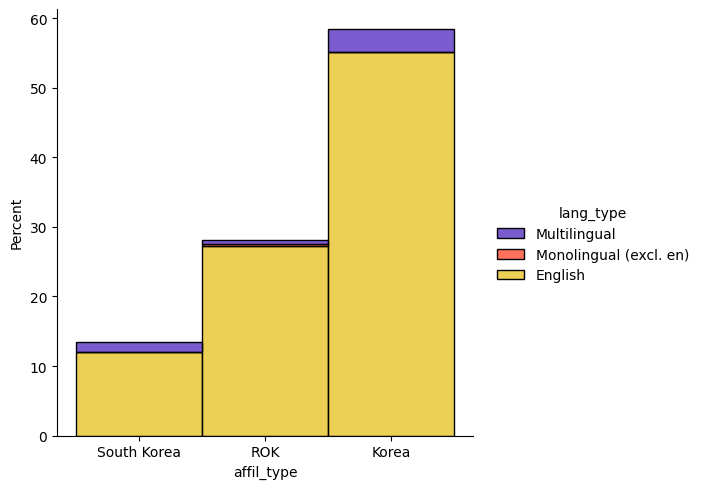

In [11]:
sns.displot(korea, x='affil_type', stat='percent', hue='lang_type',
            hue_order=['Multilingual', 'Monolingual (excl. en)', 'English'],
           palette='CMRmap', multiple='stack')

Now, we will look at 'Brasil'. This sorting function will look somewhat different as I noticed a third type present: a case in which both 'Brasil' and 'Brazil' were used. This case seemed to happen when 'Brasil' was in the name of the institution, but then the location was then noted as 'Brazil'.

In [12]:
brazil = bn.loc[(bn.affiliation.str.contains('brasil')) | (bn.affiliation.str.contains('brazil'))]
def brazil_sort(affil):
    if 'brazil' in affil.lower() and 'brasil' in affil.lower():
        return 'Both'
    elif 'brazil' in affil.lower():
        return 'Brazil'
    else:
        return 'Brasil'
brazil['affil_type'] = brazil.affiliation.map(lambda x: brazil_sort(x))
brazil = brazil.drop_duplicates('DOI')

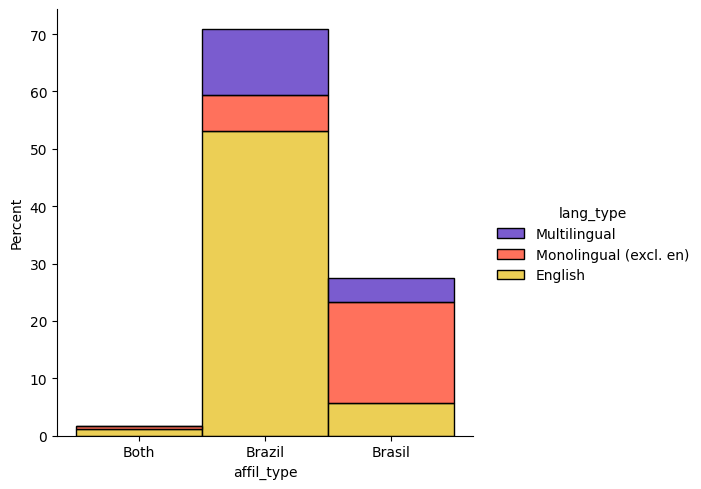

In [13]:
sns.displot(brazil, x='affil_type', stat='percent', hue='lang_type',
           hue_order=['Multilingual', 'Monolingual (excl. en)', 'English'],
            palette='CMRmap', multiple='stack')

With 'Korea' we see a defined preference for the use of the term 'Korea' irrespective of language type, however with 'Brasil' we see that there is a difference between language types.

Journals do, at times, provide guidance in how they expect certain aspects of metadata to be provided, such as what language. To examine the extent to which these decisions appear to be made at the container level, we will see how many different `affil_type` each container has. We will look at 'Korea' and then 'Brasil'.

In [14]:
grouped = korea.groupby('container-title')
groupAgg = grouped.agg({'affil_type': pd.Series.nunique})
groupAgg.value_counts()

affil_type
1             274
2              21
dtype: int64

In [15]:
grouped = brazil.groupby('container-title')
groupAgg = grouped.agg({'affil_type': pd.Series.nunique})
groupAgg.value_counts()

affil_type
1             263
2              29
dtype: int64

The data suggest that these decisions are made at the journal level, most times. In both cases an overwhelming majority of containers have only 1 of these representations, and in neither case does a journal have all 3.

### Korean Authors

Following the formats laid out by Kim & Cho (2013), we'll take a look at the different ways in which Korean names are entered into these metadata records.

First we'll pull all records published in a Korean journal or have korean as a `detected_lang`. Then we will label each record according to the format that the author name is in.

In [16]:
k_names = bn.loc[(bn['publisher'].str.contains('Korean')) | 
                (bn['container-title'].str.contains('Korean')) | 
                    (bn.detected_lang.str.contains('ko'))]
k_names

,publisher,DOI,created,title,container-title,language,deposited,published,abstract,original-title,...,lang_match,lang_type,given,family,sequence,affiliation,ORCID,authenticated-orcid,name,suffix
Index,,,,,,,,,,,,,,,,,,,,,
17,The Society of Korean Practical Arts Education...,10.29113/skpaer.2020.26.3.001,2020-09-14,나이지리아 중학교 기술 교과서의 시각자료 분석,Journal of Korean Practical Arts Education,NaN,2020-09-14,2020.0,NaN,['Analysis of Visual Materials in Nigerian Jun...,...,1.0,Multilingual,Choon-Sig,LEE,first,NaN,NaN,NaN,NaN,NaN
17,The Society of Korean Practical Arts Education...,10.29113/skpaer.2020.26.3.001,2020-09-14,나이지리아 중학교 기술 교과서의 시각자료 분석,Journal of Korean Practical Arts Education,NaN,2020-09-14,2020.0,NaN,['Analysis of Visual Materials in Nigerian Jun...,...,1.0,Multilingual,NaN,NaN,first,NaN,NaN,NaN,Gyeongin National University of Education,NaN
234,Korean Association of Human Ecology,10.5934/kjhe.2021.30.4.553,2021-09-03,The Narrative Relevance of Picture Book Endpap...,Korean Journal of Human Ecology,en,2021-09-08,2021.0,NaN,['그림책 면지의 서사적 관련성: 서사 구성요소를 중심으로'],...,0.0,English,Areum,Nam,first,NaN,NaN,NaN,NaN,NaN
234,Korean Association of Human Ecology,10.5934/kjhe.2021.30.4.553,2021-09-03,The Narrative Relevance of Picture Book Endpap...,Korean Journal of Human Ecology,en,2021-09-08,2021.0,NaN,['그림책 면지의 서사적 관련성: 서사 구성요소를 중심으로'],...,0.0,English,Sanglim,Kim,additional,NaN,NaN,NaN,NaN,NaN
478,Korean Institute of Electromagnetic Engineerin...,10.5515/kjkiees.2016.27.7.581,2016-09-02,A Study on an Improvement Scheme of ISM Manage...,The Journal of Korean Institute of Electromagn...,en,2016-12-15,2016.0,NaN,['전파응용설비 관리제도 개선방안 연구'],...,0.0,English,Yeon-Gyu,Park,first,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105608,The Korean Society of Phycology,10.4490/algae.2017.32.3.8,2017-03-24,Ingestion rate and grazing impact by the mixot...,ALGAE,en,2019-07-26,2017.0,NaN,NaN,...,0.0,English,Yeong Du,Yoo,additional,NaN,NaN,NaN,NaN,NaN
105627,Korean Society of Precision Engineering,10.7736/kspe.2017.34.8.539,2017-08-14,A Study on the Fabrication of Slot-Die Coater ...,Journal of the Korean Society for Precision En...,en,2020-04-27,2017.0,NaN,['3D 프린터를 이용한 PDMS 기반 슬롯-다이 Coater 제작에 관한 연구'],...,0.0,English,Seongyong,Kim,first,NaN,NaN,NaN,NaN,NaN
105627,Korean Society of Precision Engineering,10.7736/kspe.2017.34.8.539,2017-08-14,A Study on the Fabrication of Slot-Die Coater ...,Journal of the Korean Society for Precision En...,en,2020-04-27,2017.0,NaN,['3D 프린터를 이용한 PDMS 기반 슬롯-다이 Coater 제작에 관한 연구'],...,0.0,English,Changwoo,Lee,additional,NaN,NaN,NaN,NaN,NaN


In [17]:
from nltk.tokenize import wordpunct_tokenize
def name_analyzer(author):
    try:
        if len(author) == 1:
            return 'Initials'
        else:
            tokenizer = wordpunct_tokenize(author)
            # This is the Given-Given format
            if '-' in tokenizer:
                return 'Gn-Gn'
            elif '.' in tokenizer:
                return 'Initials'
            else:
                if len(tokenizer) > 1:
                    # This is the Given Given format
                    return 'Gn Gn'
                else:
                    detector = re.search(r"[A-Z]([a-z]){2,}[A-Z]", author)
                    if detector:
                        # The GivenGiven format
                        return 'GnGn'
                    else:
                        # The Givengiven format
                        return 'Gngn'
    except:
        return None
    
k_names['name_type'] = k_names.given.map(lambda x: name_analyzer(x))

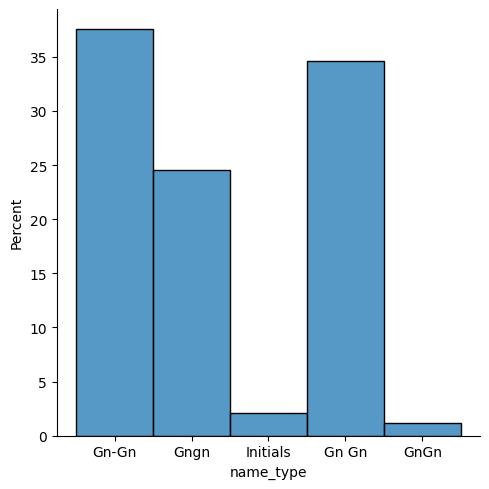

In [18]:
k_names = k_names.drop_duplicates('DOI')
sns.displot(k_names, x='name_type',
           stat='percent')
            

Our top 3 formats are in line with the top 3 that Kim & Cho (2013) found, the percentages are different, but that could be ascribed to the difference in sample sizes; we have ~2200 authors and they looked at ~196,000.